In [13]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Treći zadatak
<hr>

### Bilateralni filtar
<hr>
<p>Bilateralni filtar je filtar čija težinska funkcija zavisi, ne samo od pozicije u prozoru, već i od vrednosti piksela obuhvaćenih prozorom. Kako težinska funkcija zavisi od položaja u slici, bilateralni filtar je komplikovaniji za izračunavanje.</p>

<p>Težinska funkcija bilateralnog filtra data je sledećom formulom:</p>


\begin{equation}
w[k,l] = e^{-\displaystyle\frac{k^2 + l^2}{2\sigma_s^2}} e^{-\displaystyle\frac{(x[m + k, n + l] - x[m, n])^2}{2\sigma_r^2}} 
\end{equation}

<br>
$$ k, l \in [-r, r]$$
$$m \in [0, M - 1]$$
$$n \in [0, N - 1]$$


<p>Gde je $r$ radijus maske, $M$ i $N$ dimenzije slike, $k$ i $l$ prostorne koordinate unutar prozora, $m$ i $n$ koordinate piksela u slici, a $\sigma_s$ i $\sigma_r$ parametri filtra</p>

<p>Ideja bilateralnog filtra je da zamućuje sliku ali da detektuje ivice u slici i tada selektivno zamuti samo jednu stranu ivice, samim tim ih čuvajući.</p>


In [1]:
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.restoration import denoise_bilateral
from numpy.lib.stride_tricks import as_strided
from timeit import default_timer as timer
from IPython.display import display, HTML

out = display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [2]:
# konverzija slike u sivu
def gray_copy(original):
    gray = rgb2gray(original)
    gray = gray * 255
    gray = gray.astype(np.uint8)
    return gray

# smisliti kako ovo objasniti
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)

# gausov prozor, ne zavisi od pozicije u slici
def spatial_kernel(r, sigma_s):
    A = np.arange(-r, r + 1)
    A = np.einsum("i,i->i", A, A)
    return np.exp(-(np.tile(A, (2 * r + 1, 1)) + np.tile(A, (2 * r + 1, 1)).T) / (2 * sigma_s ** 2))


### Učitavanje
Učitavamo sliku i pretvaramo je u sivu sliku.

In [3]:
my_image = np.array(image.imread('sekvence/nice.jpg'))
img = gray_copy(my_image)

### Algoritam
* Funkcija prvo izvrši proveru ispravnosti ulaznih podataka. Ako ulazni podaci nisu odgovarajućeg tipa podiže se izuzetak.
<p><br></p>
* Ulazna slika se proširuje za r piksela sa svake strane kopiranjem ivica
<p><br></p>

* Od slike napravimo 4D niz koji možemo da zamislimo kao tablu za Sudoku. Ovo radimo jednom kako ne bismo morali da pronalazimo okolne piksele za svaki piksel originalne slike tokom iteracije već to uradimo jednom na početku. Iako je 4D slika dimenzija N x M x (2r + 1) x (2r + 1), ona ne zauzima značajnu dodatnu memoriju jer je uz pomoć funkcije _as_strided_ dobijamo kao _view_ odnosno _pogled_ na originalnu sliku. Ova ušteda u memoriji dolazi sa ograničenjem da takvu sliku onda ne možemo menjati, ne možemo upisivati vrednosti u nju (tehnički možemo, ali rezultati neće biti smisleni).

<!-- <img src="sudoku.png" alt="Sudoku"> -->
![Drag Racing](image/sudoku.png)
<p style="text-align:center;">Sudoku tabla - u htmlu je slika bila centrirana<br></p>

<p>Svaka podtabla (podslika, 2D slika) u glavnoj tabli za sudoku predstavlja prozor originalne slike nad kojim se radi filtriranje, a svaka sledeća podtabla predstavlja taj prozor pomeren za jedan red ili kolonu kao na sledećem primeru:</p>

<!-- <img src="image/filt_gif.gif" alt="Filtriranje"> -->
![Alt Text](image/filt_img.png)


<p style="text-align:center;">Filtriranje - u html je bilo .gif centriran, u PDF-u je slika<br></p>

* Iteriramo kroz svaku podsliku, računamo težinsku funkciju za svaku od njih i kao novi piksel filtrirane slike na toj poziciji vratimo korelaciju podslike i težinske funkcije. Korelacija se vrši funkcijom np.einsum, koja menja dvostruku for petlju kroz prozor, radi bržeg izvršavanja programa.


* Sva izračunavanja se obavljaju nad brojevima u pokretnom zarezu pa je na kraju potrebno pretvoriti sliku u originalni format.

In [4]:
def bilateral_filter(img, r, sigma_s, sigma_r):
    
    
    # Provere tipa i skaliranje
    if img.dtype == np.uint8:
        
        img_double = img.astype(np.double) / 255.0

    elif img.dtype == np.double:
        img_double = img
    else:
        raise TypeError("Slika mora biti tipa uint8 ili double\nSlika koje je prosledjena je tipa:\t" + str(img.dtype))
        
    
    
    # padding
    # prosiriti sliku sa po r piksela sa ivice
    padded_img = np.pad(img_double, [r, r], mode="edge")
    
    # 4d slika
    img_4d = make_4d_array(padded_img, r)

    # novi niz
    filtered_img = np.zeros_like(img_double)

    # prostorni kernel
    ws = spatial_kernel(r, sigma_s)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            wr = np.exp(-((img_4d[i, j] - img_4d[i, j, r, r]) ** 2) / (2 * sigma_r ** 2))
            W = wr * ws  # element-wise
            W = W / np.sum(W)  # normalizacija

            # korelacija
            filtered_img[i, j] = np.einsum('ij, ij->', img_4d[i, j], W)
            
    if img.dtype == np.uint8:
        
        filtered_img *= 255.0
        return filtered_img.astype(np.uint8)

    elif img.dtype == np.double:
        return filtered_img
    else:
        raise TypeError("Slika mora biti tipa uint8 ili double\nSlika koje je prosledjena je tipa:\t" + str(img.dtype))

### Brzina izvršavanja i poređenje

In [5]:
r = [2, 4, 20, 40, 80]
sigma_s = 10
sigma_r = 0.1

filtered_img_viktor = []
t_viktor = []

filtered_img_scikit = []
t_scikit = []


for i in range(len(r)):
    # viktor
    start = timer()

    filtered_img_viktor.append(bilateral_filter(img, r[i], sigma_s, sigma_r))
    
    end = timer()
    t_viktor.append(end - start)
    
    # scikit
    img_double = img.astype(np.double) / 255.0 
    start = timer()

    filtered_img_scikit.append(denoise_bilateral(img_double, win_size=2*r[i] + 1, sigma_color=sigma_r, sigma_spatial=sigma_s))
    
    end = timer()
    t_scikit.append(end - start)

r [pix] 	t_Viktor [s] 		t_scikit [s]
------------------------------------------------------------------
2 		5.144	 		0.070	
4 		5.464	 		0.215	
20 		10.232	 		4.413	
40 		24.764	 		17.174	
80 		70.870	 		69.099	

r [pix] 	t_Viktor [us/pix] 	t_scikit [us/pix]
------------------------------------------------------------------
2 		22.327	 		0.305	
4 		23.715	 		0.935	
20 		44.411	 		19.153	
40 		107.484	 		74.539	
80 		307.595	 		299.908	


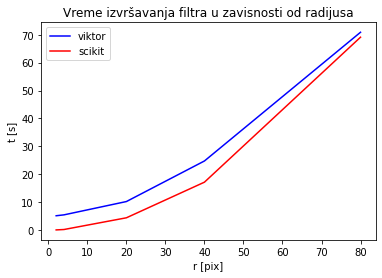

In [6]:
pix_num = img.shape[0] * img.shape[1]

print("r [pix]", "\tt_Viktor [s]", "\t\tt_scikit [s]")
print("------------------------------------------------------------------")
for i in range(len(r)):
    print(r[i], "\t\t%.3f\t" % t_viktor[i], "\t\t%.3f\t" % t_scikit[i])

print("\nr [pix]","\tt_Viktor [us/pix]", "\tt_scikit [us/pix]")
print("------------------------------------------------------------------")

for i in range(len(r)):
    print(r[i], "\t\t%.3f\t" % (t_viktor[i]/pix_num*1e6), "\t\t%.3f\t" % (t_scikit[i]/pix_num*1e6))


plt.plot(r, t_viktor, color='b', label='viktor')
plt.plot(r, t_scikit, color='r', label='scikit')
plt.ylabel("t [s]")
plt.xlabel("r [pix]")
plt.title("Vreme izvršavanja filtra u zavisnosti od radijusa")
plt.legend()
plt.show()

Možemo primetiti da su obe funkcije vremenske složenosti $\mathcal{O}(r^2)$, ali da moja ima odredjene konstantne vremenske troškove veće od ugrađenog.

Razmotrimo sada učinak filtra za različite vrednosti parametara.

### Promena parametara

#### Promena $\sigma_r$

In [7]:
r = 10
sigma_s = 7
sigma_r = [0.1, 0.5, 0.9]

filtered_img = []

for i in range(len(sigma_r)):
    filtered_img.append(bilateral_filter(img, r, sigma_s, sigma_r[i]))                        

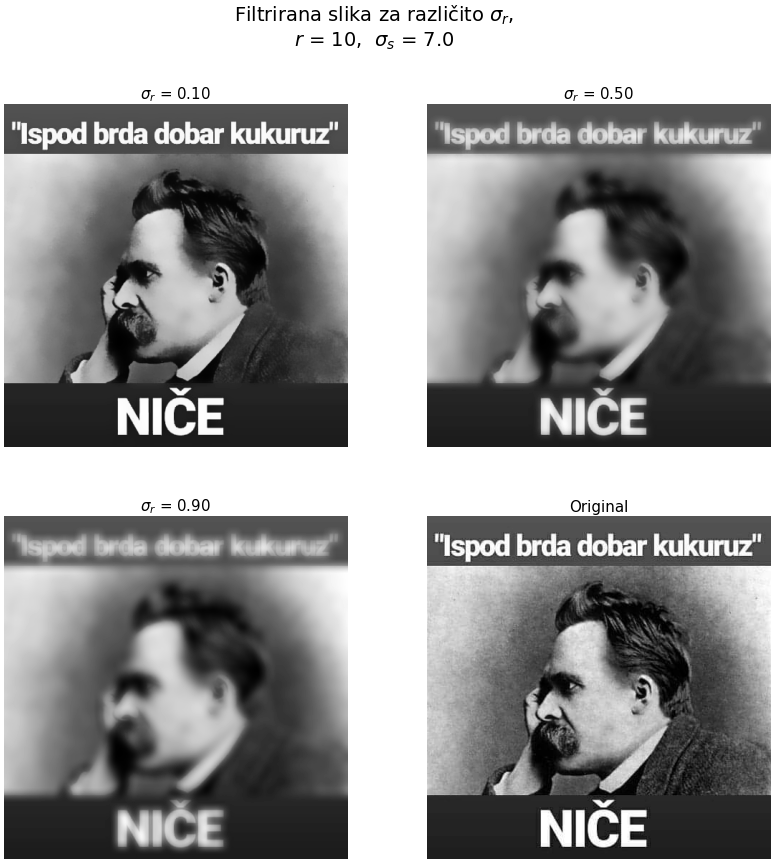

In [8]:
fontsize = 27
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(sigma_r)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$\sigma_r$ = " + "%.2f" % sigma_r[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')


ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $\sigma_r$,\n$r$ = " + "%d, " % r + " $\sigma_s$ = " + "%.1f" % sigma_s, fontsize=1.3*fontsize)
plt.show()

Možemo primetiti da kako povećavamo $\sigma_r$ tako član težinske finkcije sa $\sigma_r$ ima manje efekta i tada filtar sve više liči na običan Gausov.

#### Promena $\sigma_s$

In [9]:
r = 10
sigma_s = [1, 10, 20]
sigma_r = 0.1

filtered_img = []

for i in range(len(sigma_s)):
    filtered_img.append(bilateral_filter(img, r, sigma_s[i], sigma_r))     

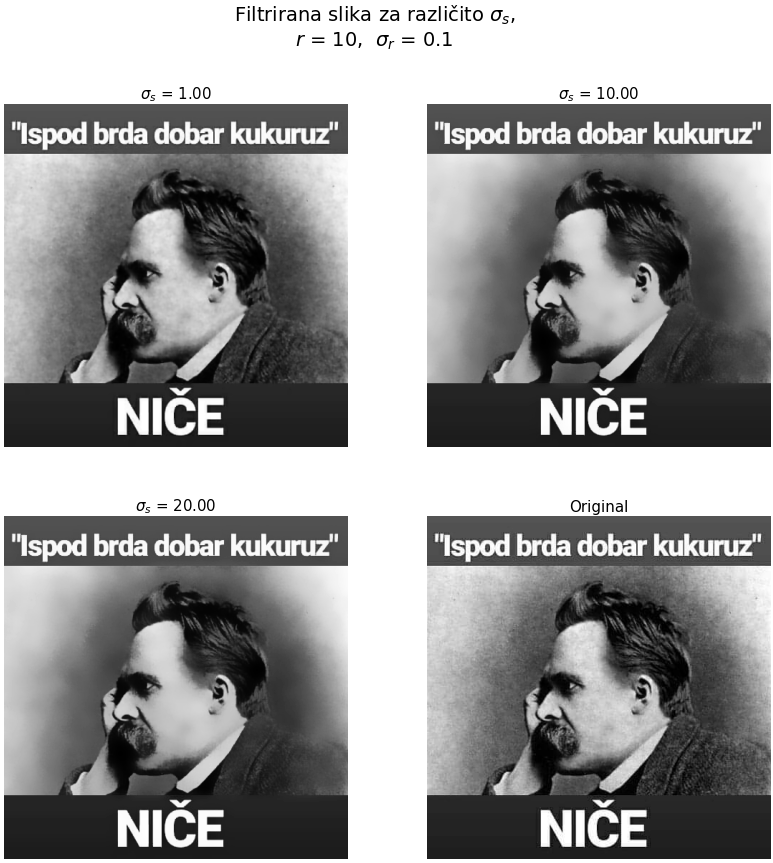

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(sigma_s)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$\sigma_s$ = " + "%.2f" % sigma_s[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')

ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $\sigma_s$,\n$r$ = " + "%d, " % r + " $\sigma_r$ = " + "%.1f" % sigma_r, fontsize=1.3*fontsize)
plt.show()

Kako povećavamo $\sigma_s$ tako dajemo veću težinu pikselima udaljenim od centralnog i intenzitet je sve uniformniji. Ali pošto smo odabrali odgovarajuće $\sigma_r$ ivice su i dalje očuvane.

#### Promena $r$

In [11]:
r = [2, 10, 40]
sigma_s = 10
sigma_r = 0.1

filtered_img = []

for i in range(len(r)):
    filtered_img.append(bilateral_filter(img, r[i], sigma_s, sigma_r))

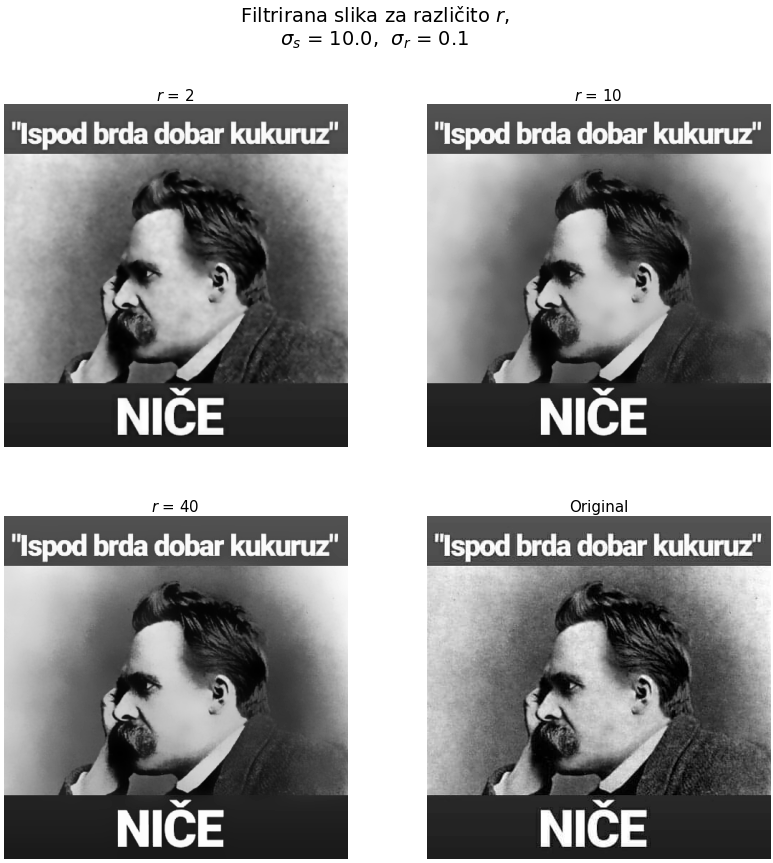

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(25,25), dpi=40);

for i in range(len(r)):
    ax[i // 2, i % 2].imshow(filtered_img[i], cmap="gray")
    ax[i // 2, i % 2].set_title("$r$ = " + "%d" % r[i], fontsize=fontsize)
    ax[i // 2, i % 2].axis('off')

ax[1, 1].imshow(img, cmap="gray")
ax[1, 1].set_title("Original", fontsize=fontsize)
ax[1, 1].axis('off')
fig.suptitle("Filtrirana slika za različito $r$,\n$\sigma_s$ = " + "%.1f, " % sigma_s + " $\sigma_r$ = " + "%.1f" % sigma_r, fontsize=1.3*fontsize)
plt.show()

Kako povećavamo $r$ tako obuhvatamo veću površinu koju na određeni način usrednjavamo i intenzitet je sve uniformniji. Kako smo odabrali odgovarajuće $\sigma_r$ ivice su i dalje očuvane.

In [14]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>